# CAPM - Capital Asset Pricing Model 

## simple linear regression으로 CAPM을 Modeling
- market portfolio 는 S&P500 사용
- Apple 단일 주식 portfolio 사용

### CAPM 공식 이용
### $ r_i = r_f + \beta * (r_m - r_f )$

In [25]:
import pandas as pd
import seaborn as sns
import plotly.express as px
from copy import copy
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [5]:
stocks_df = pd.read_csv('data/stock.csv')
stocks_df.head()

,Date,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
0,2012-01-12,60.198570,75.510002,30.120001,12.13,175.929993,180.550003,28.250000,313.644379,1295.500000
1,2012-01-13,59.972858,74.599998,30.070000,12.35,178.419998,179.160004,22.790001,311.328064,1289.089966
2,2012-01-17,60.671429,75.239998,30.250000,12.25,181.660004,180.000000,26.600000,313.116364,1293.670044
3,2012-01-18,61.301430,75.059998,30.330000,12.73,189.440002,181.070007,26.809999,315.273285,1308.040039
4,2012-01-19,61.107143,75.559998,30.420000,12.80,194.449997,180.520004,26.760000,318.590851,1314.500000


날짜를 기준으로 데이터를 정렬하고 날짜를 인덱스로 설정

In [6]:
# 'Date' 컬럼을 기준으로 데이터프레임을 오름차순으로 정렬하고, 'Date' 컬럼을 인덱스로 설정
# 이렇게 하면 시계열 데이터를 시간 순서대로 쉽게 다룰 수 있습니다.
stocks_df = stocks_df.sort_values(by = ['Date']).set_index('Date')

stocks_df.head()

,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
Date,,,,,,,,,
2012-01-12,60.198570,75.510002,30.120001,12.13,175.929993,180.550003,28.250000,313.644379,1295.500000
2012-01-13,59.972858,74.599998,30.070000,12.35,178.419998,179.160004,22.790001,311.328064,1289.089966
2012-01-17,60.671429,75.239998,30.250000,12.25,181.660004,180.000000,26.600000,313.116364,1293.670044
2012-01-18,61.301430,75.059998,30.330000,12.73,189.440002,181.070007,26.809999,315.273285,1308.040039
2012-01-19,61.107143,75.559998,30.420000,12.80,194.449997,180.520004,26.760000,318.590851,1314.500000


price를 시작일 price로 normalize하는 함수

In [12]:
def normalize(df):
    x = df.copy()   # 데이터프레임 복사본을 만듭니다.
    for col in x.columns:
        # 각 컬럼의 모든 값을 그 컬럼의 첫 번째 값으로 나누어, 데이터를 정규화합니다.
        # 이는 모든 시계열 데이터를 첫 날의 값에 대해 상대적인 변화로 표현합니다.
        x[col] = x[col]/x[col].iloc[0]
    return x   # 정규화된 데이터프레임을 반환

<Axes: xlabel='Date'>

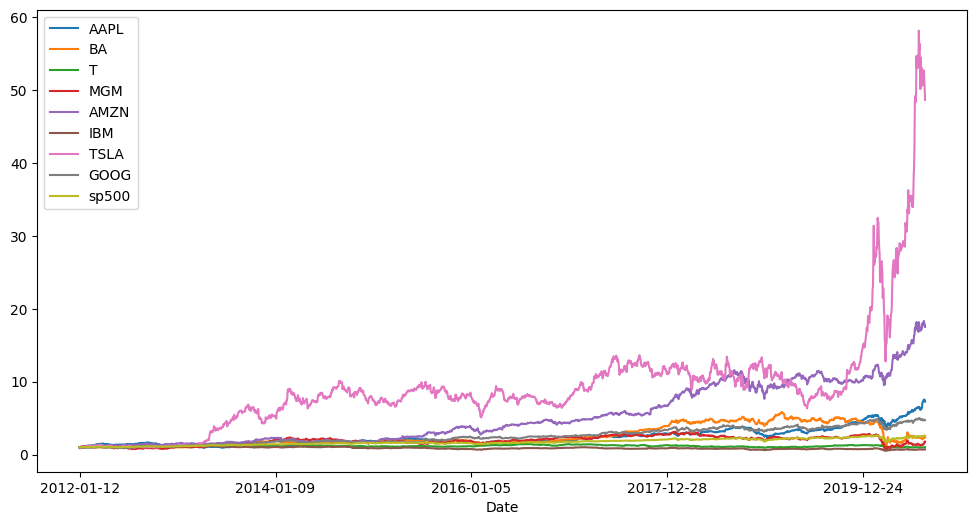

In [13]:
normalize(stocks_df).plot(figsize=(12, 6))

- 일일 수익률 계산

In [17]:
#일일 수익률 계산 
daily_returns = stocks_df.pct_change()

# 첫 번째 행의 NaN 제거
daily_returns.dropna(inplace=True)
daily_returns.head()

,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
Date,,,,,,,,,
2012-01-13,-0.003749,-0.012051,-0.001660,0.018137,0.014153,-0.007699,-0.193274,-0.007385,-0.004948
2012-01-17,0.011648,0.008579,0.005986,-0.008097,0.018159,0.004689,0.167179,0.005744,0.003553
2012-01-18,0.010384,-0.002392,0.002645,0.039184,0.042827,0.005944,0.007895,0.006889,0.011108
2012-01-19,-0.003169,0.006661,0.002967,0.005499,0.026446,-0.003038,-0.001865,0.010523,0.004939
2012-01-20,-0.017417,-0.000529,0.002959,-0.012500,-0.018102,0.044316,-0.005979,-0.083775,0.000669


In [18]:
# 각 주식의 평균 일일 수익률 계산
mean_daily_returns = daily_returns.mean()

# 가장 높은 수익률을 가진 주식부터 내림차순 정렬
sorted_mean_daily_returns = mean_daily_returns.sort_values(ascending=False)
sorted_mean_daily_returns

TSLA     0.002385
AMZN     0.001512
AAPL     0.001077
GOOG     0.000844
BA       0.000659
MGM      0.000647
sp500    0.000493
T        0.000082
IBM     -0.000061
dtype: float64

### 단일 주식에 대한 베타 계산
- 단일 주식의 일일 수익률

In [19]:
stock = 'AAPL'
stock_name = 'Apple'

In [20]:
daily_returns.head()

,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
Date,,,,,,,,,
2012-01-13,-0.003749,-0.012051,-0.001660,0.018137,0.014153,-0.007699,-0.193274,-0.007385,-0.004948
2012-01-17,0.011648,0.008579,0.005986,-0.008097,0.018159,0.004689,0.167179,0.005744,0.003553
2012-01-18,0.010384,-0.002392,0.002645,0.039184,0.042827,0.005944,0.007895,0.006889,0.011108
2012-01-19,-0.003169,0.006661,0.002967,0.005499,0.026446,-0.003038,-0.001865,0.010523,0.004939
2012-01-20,-0.017417,-0.000529,0.002959,-0.012500,-0.018102,0.044316,-0.005979,-0.083775,0.000669


선택한 주식과 S&P500(시장) 사이의 산점도를 플로팅합니다.

In [21]:
daily_returns[['AAPL', 'sp500']].head()

,AAPL,sp500
Date,,
2012-01-13,-0.003749,-0.004948
2012-01-17,0.011648,0.003553
2012-01-18,0.010384,0.011108
2012-01-19,-0.003169,0.004939
2012-01-20,-0.017417,0.000669


<Axes: xlabel='AAPL', ylabel='sp500'>

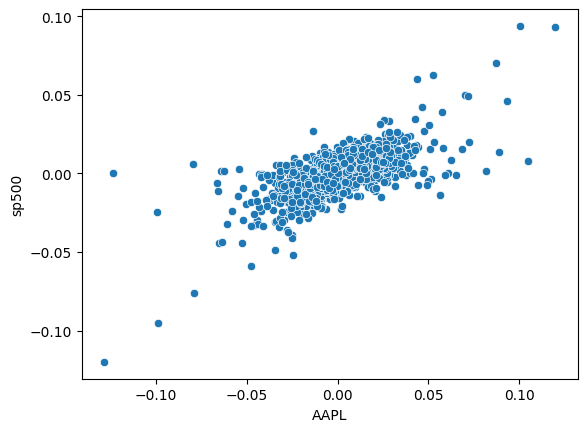

In [22]:
import seaborn as sns

# 'AAPL'과 'sp500'의 일일 수익률을 산점도로 표시
# x축은 'AAPL'의 일일 수익률을, y축은 'sp500'의 일일 수익률을 나타내며, 
# 각 점은 특정 거래일의 수익률을 나타냅니다.
sns.scatterplot(x=daily_returns['AAPL'], y=daily_returns['sp500'])

### Linear Regression을 이용한 BETA 계산

In [23]:
X = daily_returns['sp500'].values.reshape(-1, 1)
y = daily_returns['AAPL']
X.shape, y.shape

((2158, 1), (2158,))

In [26]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X, y)

lr.coef_, lr.intercept_

(array([1.11289132]), 0.000528366115486677)

알파는 시장(S&P500)을 이길 수 있는 전략의 능력을 나타냅니다.  

알파는 "초과 수익률" 또는 "비정상적 수익률"을 나타내며 예를 들어 0.00175 알파는 포트폴리오의 수익률이 벤치마크 S&P500 지수를 0.17% 초과했음을 의미합니다.

In [27]:
beta = lr.coef_[0]
alpha = lr.intercept_
print(f"{stock} 주식의 BETA = {beta}, alpha = {alpha}")

AAPL 주식의 BETA = 1.1128913172512678, alpha = 0.000528366115486677


### 증권시장선 Line plot  
베타와 알파 값은 캐피탈 자산 가격 모델(CAPM)에서 파생되며, 주식의 시장 대비 위험과 기대 수익률을 나타내는 지표입니다.

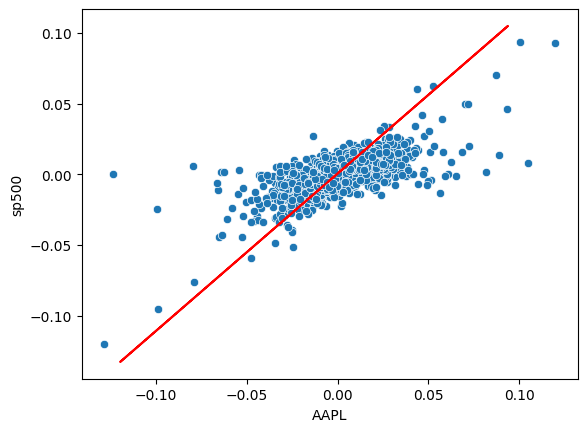

In [28]:
# 산점도 위에 선형 회귀선을 그립니다. 'sp500' 수익률에 대한 'AAPL' 수익률의 선형 관계를 나타내며, 
# 베타(beta)는 기울기, 알파(alpha)는 y절편을 의미합니다. 이 선은 'AAPL'과 'sp500' 수익률 간의 관계를 나타냅니다.
sns.scatterplot(x=daily_returns['AAPL'], y=daily_returns['sp500'])
plt.plot(daily_returns['sp500'], beta * daily_returns['sp500'] + alpha, 'r')

## beta를 구한 개별 주식에 CAPM 공식 적용
- 개별 주식의 기대 수익률 계산
### $ r_i = r_f + \beta * (r_m - r_f )$   

In [29]:
print(f"{stock} 주식의 BETA = {beta}")

AAPL 주식의 BETA = 1.1128913172512678


S&P500의 일일 평균 수익률

In [30]:
daily_returns['sp500'].mean()

0.0004933885924478228

S&P500의 연간 수익률

In [31]:
rm = daily_returns['sp500'].mean() * 252
rm

0.12433392529685133

개별 주식의 연간 수익률

In [32]:
rf = 0  # 무위험 수익률

R_i = rf + beta * (rm - rf)
R_i

0.1383701459026336

In [36]:
print(
f"""
CAPM 공식에 따르면,
단순히 마켓 인덱스에 투자할 때 연 {rm * 100:.2f}%의 수익이 기대되나, 
{stock_name} 주식에 투자할 때는 연 {R_i * 100:.2f}%의 수익이 기대된다. 
==> 공격적 투자.
""")


CAPM 공식에 따르면,
단순히 마켓 인덱스에 투자할 때 연 12.43%의 수익이 기대되나, 
Apple 주식에 투자할 때는 연 13.84%의 수익이 기대된다. 
==> 공격적 투자.



- AT&T의 기대 수익률 계산

In [34]:
stock = 'T' 

X = daily_returns['sp500'].values.reshape(-1, 1)
y = daily_returns[stock]

lr = LinearRegression()
lr.fit(X, y)

beta = lr.coef_[0]

ER_AT = rf + beta * (rm - rf)
ER_AT

0.09258276322446769

In [37]:
print(
f"""
CAPM 공식에 따르면,
단순히 마켓 인덱스에 투자할 때 연 {rm * 100:.2f}%의 수익이 기대되나, 
{stock} 주식에 투자할 때는 연 {ER_AT * 100:.2f}%의 수익이 기대된다. 
==> 방어적 투자.
""")


CAPM 공식에 따르면,
단순히 마켓 인덱스에 투자할 때 연 12.43%의 수익이 기대되나, 
T 주식에 투자할 때는 연 9.26%의 수익이 기대된다. 
==> 방어적 투자.

